In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import mplfinance as mpf
from sklearn.linear_model import LinearRegression
import itertools

In [23]:
stocks = ['RELIANCE', 'TCS', 'HDFCBANK', 'TITAN', 'BAJAJFINSV', 'ITC', 'COALINDIA', 'POWERGRID', 'NTPC', 'IDEA', 'YESBANK', 'ZEEL', 'ADANIPOWER', 'ADANIENSOL', 'ADANIPORTS']
df = yf.download('ntpc.NS', start='2024-03-01', end='2026-01-23')
df.dropna(inplace=True)

C:\Users\saksh\AppData\Local\Temp\ipykernel_16904\2489182546.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('ntpc.NS', start='2024-03-01', end='2026-01-23')
[*********************100%***********************]  1 of 1 completed


In [24]:
# Step 1: flatten the MultiIndex
df.columns = [col[0] for col in df.columns]

ohlc_cols = ["Open", "High", "Low", "Close", "Volume"]
for col in ohlc_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure your Date column is datetime and set as index
df.index = pd.to_datetime(df.index)

In [25]:
def rolling_slope(series, window):
    """
    Returns rolling linear regression slope
    """
    slopes = np.full(len(series), np.nan)

    x = np.arange(window)

    for i in range(window, len(series)):
        y = series.iloc[i-window:i].values
        slope = np.polyfit(x, y, 1)[0]
        slopes[i] = slope

    return slopes

In [26]:
def atr_mult_from_percentile(p):
    """
    p : volatility percentile (0–1)
    """
    p = max(0, min(p, 1))
    return 2.8 + 2.2 * (p ** 2.0)

In [27]:
full = df

# --------------------------------------
# 5. Compute DMAs on extended data
# --------------------------------------
full["50DMA"] = full["Close"].rolling(50).mean()
full["200DMA"] = full["Close"].rolling(200).mean()

full["H-L"] = full["High"] - full["Low"]
full["H-PC"] = abs(full["High"] - full["Close"].shift(1))
full["L-PC"] = abs(full["Low"] - full["Close"].shift(1))

full["TR"] = full[["H-L", "H-PC", "L-PC"]].max(axis=1)
full["ATR"] = full["TR"].rolling(14).mean()

full["ATR_PCT"] = full["ATR"] / full["Close"]
full["ATR_PCT_PCTL"] = full["ATR_PCT"].rolling(100).rank(pct=True)
full["ATR_MULT"] = full["ATR_PCT_PCTL"].apply(atr_mult_from_percentile)

full["VOL20DMA"] = full["Volume"].rolling(20).mean()

# RSI (14)
delta = full["Close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
full["RSI"] = 100 - (100 / (1 + rs))

# EMA calculation
full["20EMA"] = full["Close"].ewm(span=20, adjust=False).mean()
full["50EMA"] = full["Close"].ewm(span=50, adjust=False).mean()
full["200EMA"] = full["Close"].ewm(span=200, adjust=False).mean()

# Rolling slope windows
SLOPE50_WINDOW  = 7
SLOPE200_WINDOW1 = 10
SLOPE200_WINDOW2 = 13

full["DMA50_SLOPE"]  = rolling_slope(full["50DMA"], SLOPE50_WINDOW)
full["DMA200_SLOPE1"] = rolling_slope(full["200DMA"], SLOPE200_WINDOW1)
full["DMA200_SLOPE2"] = rolling_slope(full["200DMA"], SLOPE200_WINDOW2)
full["EMA50_SLOPE"]  = rolling_slope(full["50EMA"], SLOPE50_WINDOW)

# BOLLINGER BANDS (20-period)
bb_period = 20
bb_std = 2

full["BB_MID"] = full["Close"].rolling(bb_period).mean()
full["BB_STD"] = full["Close"].rolling(bb_period).std()

full["BB_UPPER"] = full["BB_MID"] + bb_std * full["BB_STD"]
full["BB_LOWER"] = full["BB_MID"] - bb_std * full["BB_STD"]
full["BB_UPPER_MID"] = full["BB_MID"] +  full["BB_STD"]
full["BB_LOWER_MID"] = full["BB_MID"] -  full["BB_STD"]

In [28]:
def get_signals(full):
    signal_buy = []
    signal_sell = []
    in_position = False
    trail_sl = None
    last_buy_price = None
    trailing_stop = None

    for i in range(200, len(full)-1):
        
        dma50      = full["50DMA"].iloc[i]
        dma200     = full["200DMA"].iloc[i]
        ema200     = full["200EMA"].iloc[i]
        bb_mid      = full["BB_MID"].iloc[i]
        bb_lower    = full["BB_LOWER"].iloc[i]
        bb_upper    = full["BB_UPPER"].iloc[i]
        bb_lowermid = full["BB_LOWER_MID"].iloc[i]
        bb_uppermid = full["BB_UPPER_MID"].iloc[i]

        # DMA slopes
        dmaslope1200 = full["DMA200_SLOPE1"].iloc[i]
        dmaslope2200 = full["DMA200_SLOPE2"].iloc[i]

        #EMA slopes
        emaslope50 = full["EMA50_SLOPE"].iloc[i]


        price = full["Close"].iloc[i]
        low_price = full["Low"].iloc[i]
        high_price = full["High"].iloc[i]
        atr = full["ATR"].iloc[i]
        rsi = full["RSI"].iloc[i]
        atr_multiplier = full["ATR_MULT"].iloc[i]

        # -----------------
        # BUY CONDITIONS
        # -----------------
        if not in_position:
            if emaslope50 > 0 and dmaslope1200 < 0 and low_price <= bb_mid:
                if(low_price<= bb_mid  <= high_price):
                    exec_price = bb_mid 
                else:
                    exec_price = price
                signal_buy.append((full.index[i],exec_price))
                last_buy_price = exec_price   # Save buy price for profit target
                in_position = True
                # initialize ATR trailing stop
                trail_sl = exec_price - atr_multiplier * atr

            # ---- STRATEGY 2: TREND CONTINUATION ENTRY ----
            if (
               dmaslope2200 > 0 and                       # Strong uptrend
                full["RSI"].iloc[i] > 60 and            # Momentum
                full["Volume"].iloc[i] > full["VOL20DMA"].iloc[i] and
                low_price <= dma50 * 1.02                   # Pullback entry
            ):
                
                if(low_price <= dma50*1.02 <= high_price):
                    exec_price = dma50 * 1.02
                else:
                    exec_price = price
                signal_buy.append((full.index[i], exec_price))
                last_buy_price = exec_price
                in_position = True
                # initialize ATR trailing stop
                trail_sl = exec_price - atr_multiplier * atr

        # SELL CONDITIONS

        else:
            # SL hit?
            if price < trail_sl:
                signal_sell.append((full.index[i], trail_sl))
                in_position = False
                trail_sl = None
                last_buy_price = None
            else:
                new_sl = price - atr_multiplier * atr
                trail_sl = max(trail_sl, new_sl)

            # Also check original sell signal (fallback)
            #elif emaslope50 < 0 and dmaslope200 > 0:
            #     signal_sell.append((full.index[i], price))
            #     in_position = False
            #     trail_sl = None
            #     last_buy_price = None

    return signal_buy, signal_sell

signal_buy, signal_sell = get_signals(full)

print("BUY SIGNAL =", signal_buy)
print("SELL SIGNAL =", signal_sell)

BUY SIGNAL = [(Timestamp('2025-04-07 00:00:00'), 328.4866395996094), (Timestamp('2025-07-24 00:00:00'), 333.46907806396484), (Timestamp('2025-08-19 00:00:00'), 329.65293884277344), (Timestamp('2025-10-06 00:00:00'), 333.5827911376953), (Timestamp('2025-12-29 00:00:00'), 325.5), (Timestamp('2026-01-12 00:00:00'), 334.4280854370117)]
SELL SIGNAL = [(Timestamp('2025-05-08 00:00:00'), 335.1643206543928), (Timestamp('2025-08-07 00:00:00'), 324.73574454109513), (Timestamp('2025-08-29 00:00:00'), 323.1614980814363), (Timestamp('2025-11-04 00:00:00'), 332.0474626656026), (Timestamp('2026-01-09 00:00:00'), 339.78462260654993)]


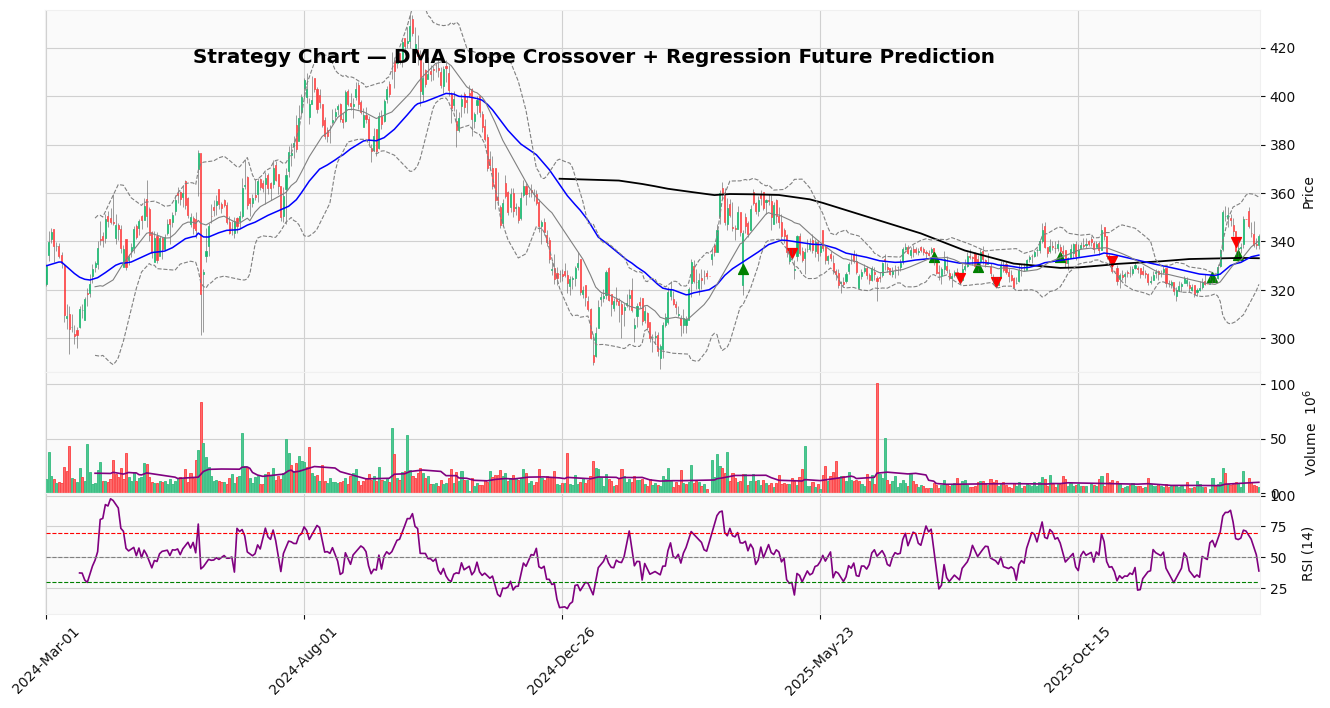

In [29]:
# Function to snap predicted date to nearest trading date
def nearest_index(target_date, index):
    return index[index.get_indexer([target_date], method='nearest')[0]]

# 6. RESET ADDPLOTS
addplots = [
    #mpf.make_addplot(full["50DMA"], color="blue", width=1.1),
    mpf.make_addplot(full["200DMA"], color="black", width=1.3),
    mpf.make_addplot(
        full["VOL20DMA"],
        panel=1,
        color="purple",
        width=1.2
    ),
    mpf.make_addplot(full["50EMA"], color="blue", width=1.1)
]

# Create empty marker series
buy_marker_series  = pd.Series(index=full.index, dtype=float)
sell_marker_series = pd.Series(index=full.index, dtype=float)

# BUY MARKERS (MULTIPLE)
for buy_date, buy_price in signal_buy:
    buy_date = nearest_index(buy_date, full.index)
    buy_marker_series.loc[buy_date] = buy_price

addplots.append(
    mpf.make_addplot(
        buy_marker_series,
        type="scatter",
        marker="^",
        color="green",
        markersize=50
    )
)

# SELL MARKERS (MULTIPLE)
for sell_date, sell_price in signal_sell:
    sell_date = nearest_index(sell_date, full.index)
    sell_marker_series.loc[sell_date] = sell_price

addplots.append(
    mpf.make_addplot(
        sell_marker_series,
        type="scatter",
        marker="v",
        color="red",
        markersize=50
    )
)

addplots.append(
    mpf.make_addplot(
        full["RSI"],
        panel=2,
        color="purple",
        width=1.2,
        ylabel="RSI (14)"
    )
)

addplots.append(
    mpf.make_addplot(
        [70] * len(full),
        panel=2,
        color="red",
        linestyle="--",
        width=0.8
    )
)

addplots.append(
    mpf.make_addplot(
        [50] * len(full),
        panel=2,
        color="gray",
        linestyle="--",
        width=0.8
    )
)

addplots.append(
    mpf.make_addplot(
        [30] * len(full),
        panel=2,
        color="green",
        linestyle="--",
        width=0.8
    )
)


addplots.extend([
    mpf.make_addplot(full["BB_UPPER"], color="grey", linestyle="dashed", width=0.8),
    mpf.make_addplot(full["BB_MID"],   color="grey", width=0.8),
    mpf.make_addplot(full["BB_LOWER"], color="grey", linestyle="dashed", width=0.8),
])

# FINAL PLOT
mpf.plot(
    full,
    type="candle",
    style="yahoo",
    addplot=addplots,
    title="Strategy Chart — DMA Slope Crossover + Regression Future Prediction",
    figsize=(14, 7),
    volume=True,
    volume_panel=1,
    panel_ratios=(6,2,2), # Price, Volume, RSI,
    tight_layout=True
)


In [30]:
# 5. STRATEGY PROFIT CALC
total_profit = 0
capital_per_trade = 25000

if signal_buy and signal_sell:

    for i in range(min(len(signal_buy), len(signal_sell))):
        buy_date  = signal_buy[i][0]
        buy_price = signal_buy[i][1]

        sell_date  = signal_sell[i][0]
        sell_price = signal_sell[i][1]

        # Profit using capital allocation
        profit = (sell_price - buy_price) * (capital_per_trade / buy_price)
        #capital_per_trade += profit
        total_profit += profit

        print(
            f"Trade {i+1}: "
            f"Buy Date = {buy_date.date()}, Buy = {buy_price:.2f}, "
            f"Sell Date = {sell_date.date()}, Sell = {sell_price:.2f}, "
            f"Profit = {profit:.2f}"
        )

    print("\n=== TOTAL STRATEGY RESULT ===")
    print("Total Profit:", total_profit)

elif signal_buy and not signal_sell:
    print("\nOnly buy signals triggered. No sell yet.")
else:
    print("\nNo buy signals found.")


Trade 1: Buy Date = 2025-04-07, Buy = 328.49, Sell Date = 2025-05-08, Sell = 335.16, Profit = 508.22
Trade 2: Buy Date = 2025-07-24, Buy = 333.47, Sell Date = 2025-08-07, Sell = 324.74, Profit = -654.73
Trade 3: Buy Date = 2025-08-19, Buy = 329.65, Sell Date = 2025-08-29, Sell = 323.16, Profit = -492.29
Trade 4: Buy Date = 2025-10-06, Buy = 333.58, Sell Date = 2025-11-04, Sell = 332.05, Profit = -115.06
Trade 5: Buy Date = 2025-12-29, Buy = 325.50, Sell Date = 2026-01-09, Sell = 339.78, Profit = 1097.13

=== TOTAL STRATEGY RESULT ===
Total Profit: 343.25433734477406
